In [88]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import zipfile

# Project Description
For this project, I am planning on using a facial data set from kaggle to identify facial features. This is very interesting to me, since it takes CNN models a step farther from binary classification. The goal will be to label X-Y coordinates for different facial features on unlabeled images. If the model is trained well then it can identify a face and its features from different angles.  This could be very useful in security cameras, identifying people in photos or videos and using the data to analyze facial expressions. I plan on only using the training set and splitting it to evaluate my model. I am going to remove some features and only focus on the features left eye center, right eye center, nose tip and middle of bottom lip. 

### Kaggle Link 
https://www.kaggle.com/competitions/facial-keypoints-detection/overview

# Data 
The data is split into a training.csv and a test.csv. The training data has columns 0-29 for 30 facial features and the last column has the image data.  The test data just has image data. The image data is a single space delineated row of pixel values. I will reformat it to float32 and 96 x 96 x 1. I'll be splitting the training data into training and validation data to train my models. The first 30 columns are x or y coordinates for a facial feature. The 30 facial feature columns are all type float64 and the image is of size 96 x 96 X 1 (so they are greyscale).

# Data size
I will be using the 7039 training images 

In [89]:
#read data in
train_df = pd.read_csv('facial-keypoints-detection/training.csv')

In [90]:
print(train_df.head(3))

   left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          66.033564          39.002274           30.227008   
1          64.332936          34.970077           29.949277   
2          65.057053          34.909642           30.903789   

   right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0           36.421678                59.582075                39.647423   
1           33.448715                58.856170                35.274349   
2           34.909642                59.412000                36.320968   

   left_eye_outer_corner_x  left_eye_outer_corner_y  right_eye_inner_corner_x  \
0                73.130346                39.969997                 36.356571   
1                70.722723                36.187166                 36.034723   
2                70.984421                36.320968                 37.678105   

   right_eye_inner_corner_y  ...  nose_tip_y  mouth_left_corner_x  \
0                 37.389402  ...   57.066803        

In [91]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

# Exploratory Data Analysis
1. I want to explore null values, plot histogram of Null vs non Null values.

2. As seen in the histogram, only 4 features are labeled for the entire training data set. The other 11 features have labels for only 2000/7000 images. As stated in my problem descripition I will be reducing the features my model evaluates to the 4 features that have no nulls in the training data set. These are right eye center, left eye center, nose tip and mouth center bottom lip.  I removed the other features after plotting the histogram. 

3. Next I transformed this smaller set of features into y_train and x_train. y_train is the coordinates for the four features and x_train is the image (now formatted into 96x96x1) that will be fed into the Model. 

4. With the image data now formatted I plotted 16 sample images to get an idea of what my model was looking at.

5. I then plotted 4 images with the labels overlaying the images to show how the data was labeled for each of the four features. 

6. Next I wanted to see the distribution of each feature. I used a log scale so I could see outliers. This shows that each facial feature has a certain zone with some outliers around it. 

7. I was also curious about the brightness distribution of the images so explored brightness of the images as well. It is pretty standard with not a lot of all white or all black pixels.

8. Plotted correlation of position of features compared to one another. The one that stands out is mouth x position related to nose x position. This makes sense since it is hard to shift the x position unless the face is turned and not up and down. This is useful to see to understand relationships between features. 

9. For the model I need to scale the images to [0,1] instead of [0,255]. I am not going to scale y since the model will learn the scale. 

10. Once my model is set up, I plan to set up an augmentation pipeline that randomly flips images and coords to give a wider variety to my model. 

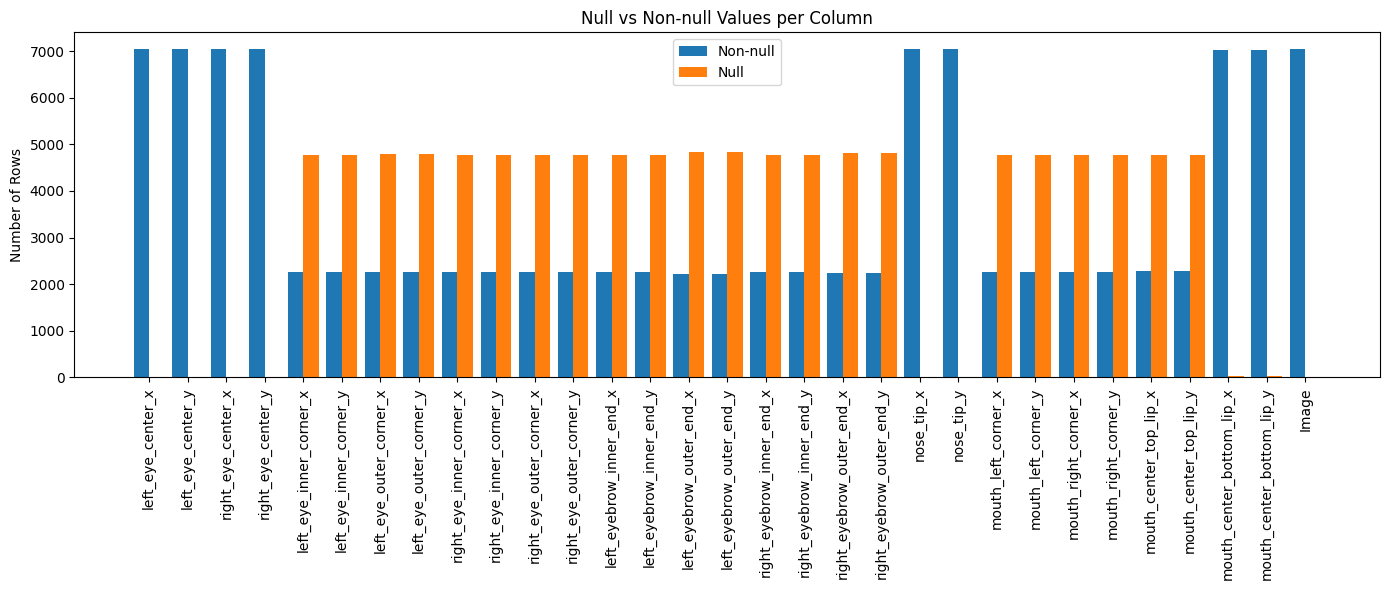

In [92]:
#Histogram of null vs non null values
import matplotlib.pyplot as plt
import numpy as np

# 1) Assume your DataFrame is called df
cols = train_df.columns

# count nulls and non-nulls
null_counts     = train_df.isna().sum()
non_null_counts = train_df.shape[0] - null_counts

# 2) build a grouped bar chart
x     = np.arange(len(cols))
width = 0.4

fig, ax = plt.subplots(figsize=(14,6))
ax.bar(x - width/2, non_null_counts, width, label='Non-null')
ax.bar(x + width/2,     null_counts, width, label='Null')

# label it
ax.set_xticks(x)
ax.set_xticklabels(cols, rotation=90)
ax.set_ylabel('Number of Rows')
ax.set_title('Null vs Non-null Values per Column')
ax.legend()
plt.tight_layout()
plt.show()


In [93]:
features = [
    'left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y',
    'nose_tip_x', 'nose_tip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image'
]
train_df = train_df[features]
print(train_df.info())

#look for NaN values
nan_counts = train_df.isna().sum()
print(nan_counts)

#remove NaN samples (drop rows with NaN
train_df = train_df.dropna(axis=0)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   nose_tip_x                 7049 non-null   float64
 5   nose_tip_y                 7049 non-null   float64
 6   mouth_center_bottom_lip_x  7016 non-null   float64
 7   mouth_center_bottom_lip_y  7016 non-null   float64
 8   Image                      7049 non-null   object 
dtypes: float64(8), object(1)
memory usage: 495.8+ KB
None
left_eye_center_x            10
left_eye_center_y            10
right_eye_center_x           13
right_eye_center_y           13
nose_tip_x                    0
nose_tip_y                    0
mouth_center_bottom_lip_x  

In [94]:
y_train = np.array(train_df.iloc[:,:8])

imgs = []
for i in range(len(train_df)):
    imgs.append(train_df['Image'].iloc[i].split(' '))

x_train = np.array(imgs, dtype='float')

x_train = x_train.reshape(x_train.shape[0],96,96)

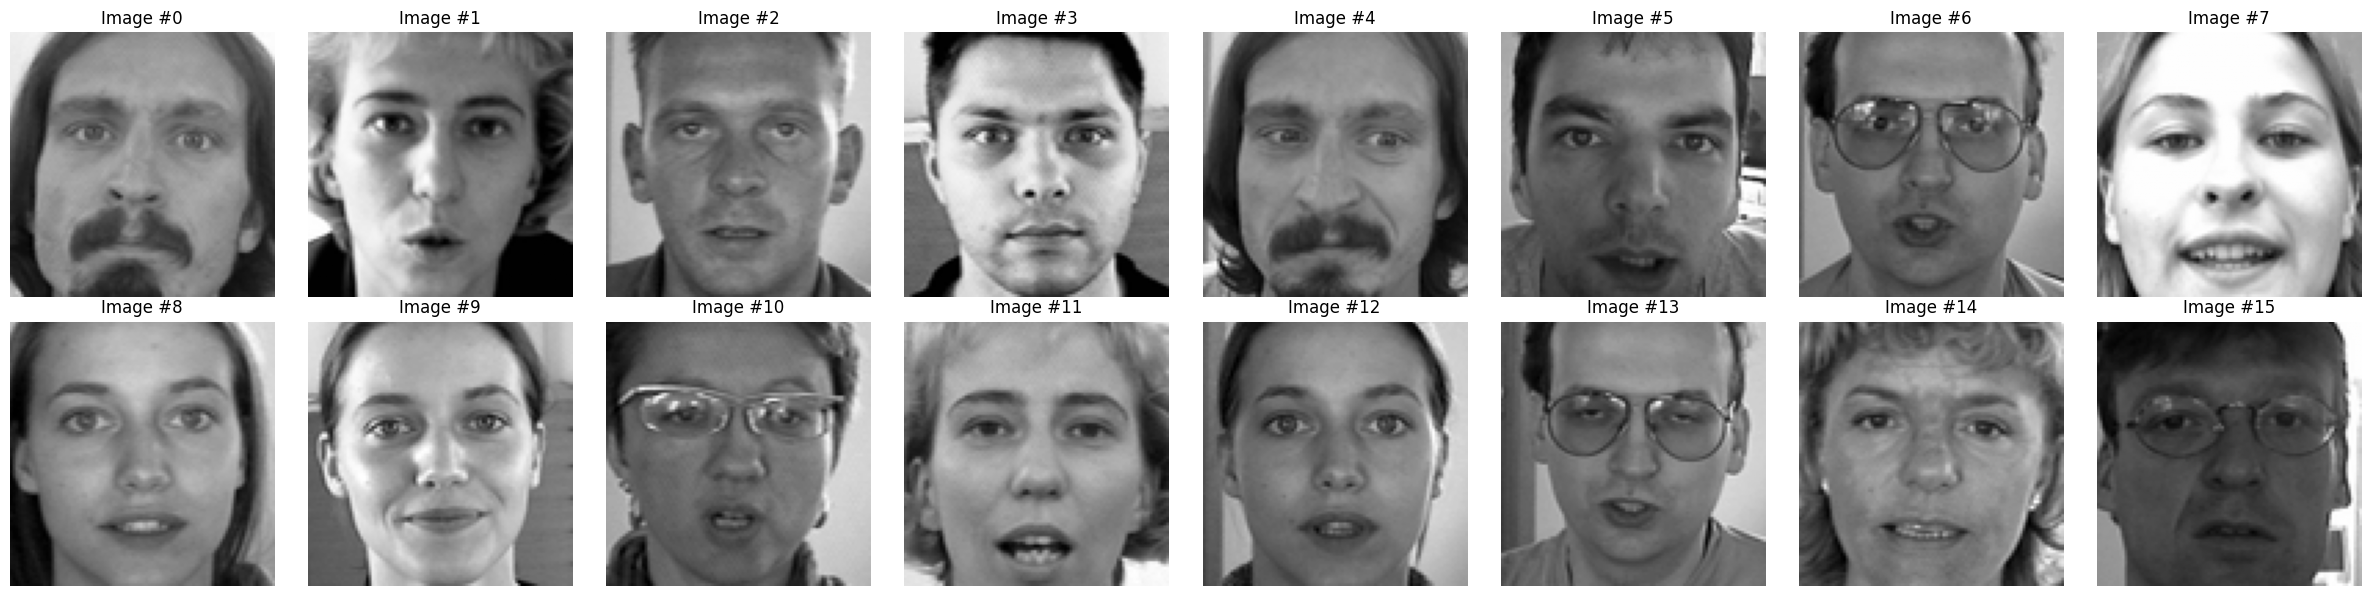

In [95]:
#can change params to see more or less
n = 16
rows, cols = 2, 8

fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

# Flatten the axes array for easy iteration
axes = axes.flatten()

#plot n images 
for i in range(n):
    ax = axes[i]
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title(f"Image #{i}")
    ax.axis('off') 

plt.tight_layout()
plt.savefig('plot8.png', bbox_inches='tight')
plt.show()


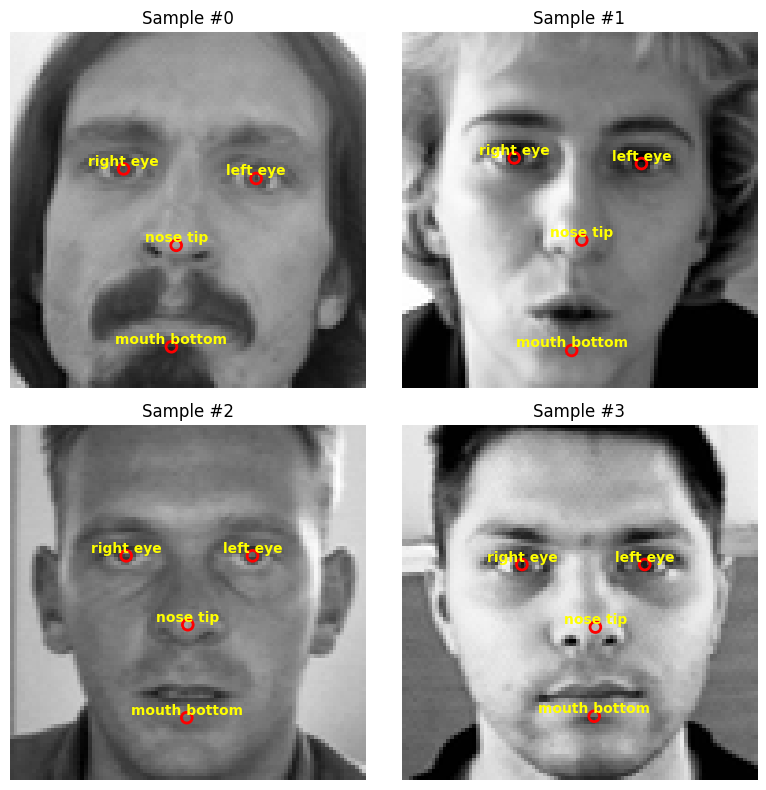

In [96]:
# number of samples to show
n_show = 4

# taking landmarks from y_train and converting them to text
landmarks = [
    ("left eye",       0, 1),
    ("right eye",      2, 3),
    ("nose tip",       4, 5),
    ("mouth bottom",   6, 7),
]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

#loop over images
for i in range(n_show):
    ax = axes[i]
    img = x_train[i]
    
    #all images are grey scale 
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Sample #{i}")

    # overlay each landmark
    for name, xi, yi in landmarks:
        x, y = y_train[i, xi], y_train[i, yi]
        ax.scatter(x, y,
                   marker='o',
                   s=60,
                   facecolors='none',
                   edgecolors='red',
                   linewidths=2)
        ax.text(x, y,
                name,
                color='yellow',
                fontsize=10,
                ha='center',
                va='bottom',
                weight='bold')

plt.tight_layout()
plt.show()


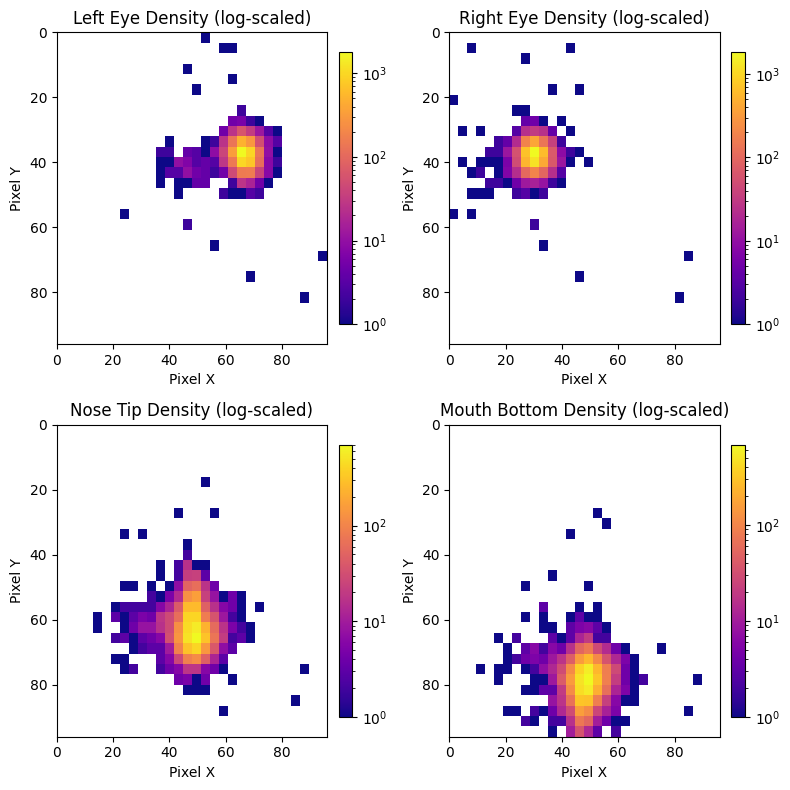

In [97]:
from matplotlib.colors import LogNorm

# This is to understand spatially where features appear most/least
landmark_info = [
    ("Left Eye",       (0, 1)),
    ("Right Eye",      (2, 3)),
    ("Nose Tip",       (4, 5)),
    ("Mouth Bottom",   (6, 7)),
]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

#loop over images
for ax, (name, (ix, iy)) in zip(axes, landmark_info):
    x = y_train[:, ix]
    y = y_train[:, iy]

    h, xedges, yedges, mesh = ax.hist2d(
        x, y,
        bins=30,
        range=[[0, 96], [0, 96]],
        norm=LogNorm(),         # changed to logNorm so I could see outliers
        cmap='plasma'           
    )
    ax.set_title(f"{name} Density (log‐scaled)")
    ax.set_xlabel("Pixel X")
    ax.set_ylabel("Pixel Y")
    ax.invert_yaxis()
    plt.colorbar(mesh, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


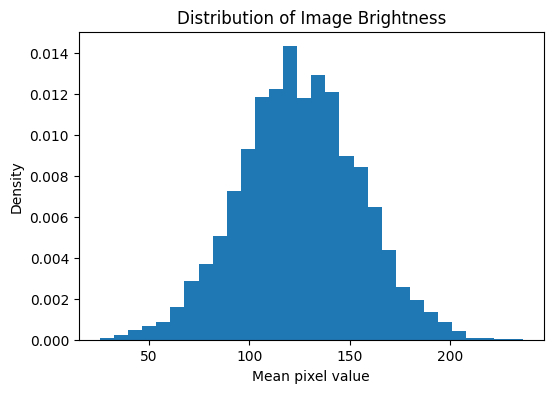

In [98]:
#Brightness graph to understand image brightness better. 
means = x_train.reshape(len(x_train), -1).mean(axis=1)

plt.figure(figsize=(6,4))
plt.hist(means, bins=30, density=True)
plt.title("Distribution of Image Brightness")
plt.xlabel("Mean pixel value")
plt.ylabel("Density")
plt.show()

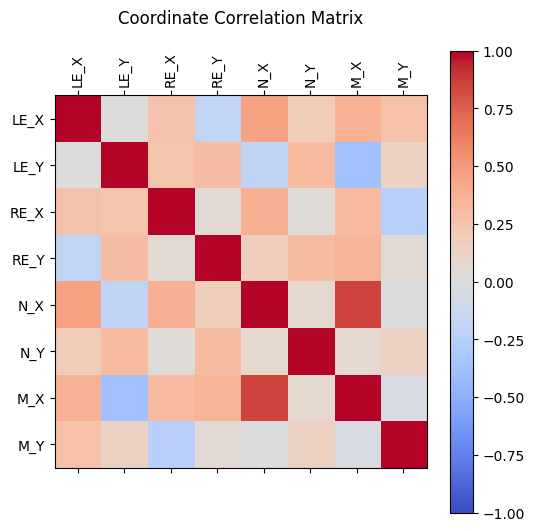

In [99]:
#correlation matrix for features
corr = np.corrcoef(y_train.T)
fig, ax = plt.subplots(figsize=(6,6))
cax = ax.matshow(corr, vmin=-1, vmax=1, cmap='coolwarm')
ax.set_xticks(range(8))
ax.set_yticks(range(8))
ax.set_xticklabels(['LE_X','LE_Y','RE_X','RE_Y','N_X','N_Y','M_X','M_Y'], rotation=90)
ax.set_yticklabels(['LE_X','LE_Y','RE_X','RE_Y','N_X','N_Y','M_X','M_Y'])
fig.colorbar(cax)
plt.title("Coordinate Correlation Matrix", pad=20)
plt.show()

In [100]:
#scale X_train for model 
x_train_scaled = x_train.astype('float32') / 255.0
#scale the Y_train for model
y_train_scaled = y_train.astype('float32') / 96.0


In [101]:
from sklearn.model_selection import train_test_split
# Split data for training and validation/testing 
x_train_scaled, x_val_scaled, y_train_scaled, y_val_scaled = train_test_split(x_train_scaled, y_train_scaled, 
    test_size=0.2, random_state=42, shuffle=True
)

# scale training data 
x_train_scaled = np.expand_dims(x_train_scaled, axis=-1) 
x_val_scaled   = np.expand_dims(x_val_scaled,   axis=-1)

# Model Building 
Now that I have cleaned data that I understand better, it is ready to be fed into a few different models
### Model 1
This Model is a simple CNN model that has 3 cov2d and maxpooling blocks with double the number of filters per block. It is then followed by a flatten layer so it can be inputted into two dense layers with a dropout in between to reduce overfitting. The last dense layer has 8 nodes for the 8 coordinates I am looking for in my model output. 

### Model 2

### Model 3

### Image augmentation

### Model Choice / Comparison 

In [102]:
# This model is a basic CNN that rudes the image size to 8 features (4 landmarks with 2 coordinates each)
def simple_cnn(input_shape=(96,96,1)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        
        layers.Dense(8, activation='linear')  
    ])
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model

In [103]:
# I want to try transfer learning in this project, So I will use resnet50 which is pretrained on millions of images. 
def resnet50_model(input_shape=(96,96,3)):
    # don't want to update resnets weights, just want to use it to extract features that it already has learned
    base = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet', #use imagenet which is the weights found by already training on imagenet
        input_shape=input_shape
    )
    base.trainable = False
    
    #create head of model 
    inputs = layers.Input((96,96,1))
    x = layers.Concatenate()([inputs, inputs, inputs])  
    x = tf.keras.applications.resnet.preprocess_input(x)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(8, activation='linear')(x) 
    
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model


In [104]:
# Use mobile net, a different pre trained model instead of resnet
def mobilenetv2_model(input_shape=(96,96,1)):
    # Have imagenet trained model here
    base = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(96,96,3)
    )
    base.trainable = False

    # convert greyscale to RGB
    inputs = layers.Input(shape=input_shape)           
    x = layers.Concatenate()([inputs, inputs, inputs])  
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    
    #layers 
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    # final output with 8 coordinates
    outputs = layers.Dense(8, activation='linear')(x)
    
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model



In [106]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# setting up pipeline to train on each model above with augmentation of data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)

# contains information about three models
builders = [
    ("Model_CNN_Simple", simple_cnn),
    ("Model_ResNet", resnet50_model),
    ("Model_MobilnetV2", mobilenetv2_model),
]

histories = {}
batch_size = 32

# loop through each model and add model info to history 
for name, build_fn in builders:
    tf.keras.backend.clear_session()
    print(f"\nTraining {name}…")
    
    model = build_fn()
    
    # set up generator for x and y training data
    train_gen = train_datagen.flow(
        x_train_scaled, 
        y_train_scaled, 
        batch_size=batch_size, 
        shuffle=True
    )
    
    history = model.fit(
        train_gen,
        steps_per_epoch=len(x_train)//batch_size,
        epochs=20,
        validation_data=(x_val_scaled, y_val_scaled)
    )
    
    histories[name] = history



Training Model_CNN_Simple…
Epoch 1/2
218/218 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - loss: 0.0498 - mae: 0.1624 - val_loss: 10.5633 - val_mae: 3.0142
Epoch 2/2
218/218 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - loss: 0.0099 - mae: 0.0776 - val_loss: 9.5764 - val_mae: 2.8559

Training Model_ResNet…
Epoch 1/2
218/218 ━━━━━━━━━━━━━━━━━━━━ 38s 166ms/step - loss: 0.2857 - mae: 0.3316 - val_loss: 0.0110 - val_mae: 0.0875
Epoch 2/2
218/218 ━━━━━━━━━━━━━━━━━━━━ 35s 158ms/step - loss: 0.0292 - mae: 0.1341 - val_loss: 0.0080 - val_mae: 0.0716

Training Model_MobilnetV2…
Epoch 1/2
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.2475 - mae: 0.3168 - val_loss: 0.0227 - val_mae: 0.1389
Epoch 2/2
218/218 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0326 - mae: 0.1420 - val_loss: 0.0027 - val_mae: 0.0381


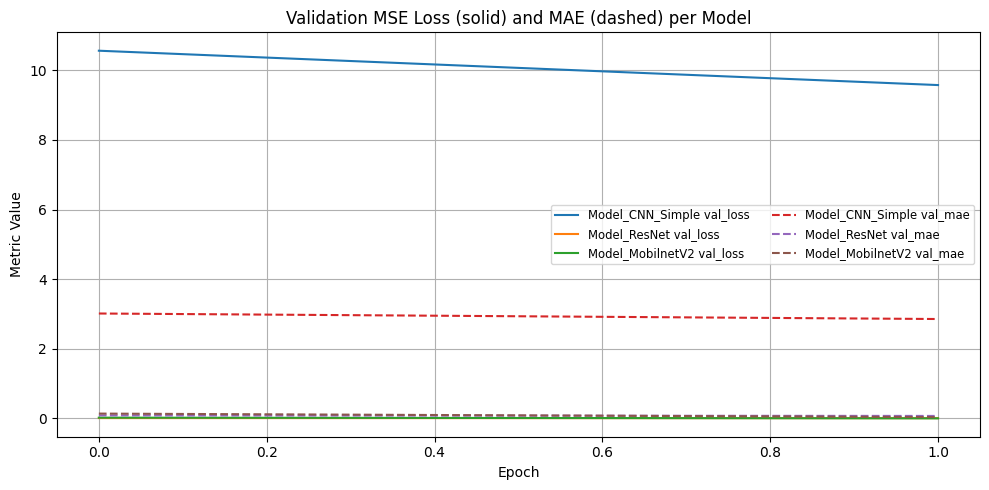

In [107]:
# histories is dict of all models histories, use that to plot losses
plt.figure(figsize=(10,5))

# Plot Validation Loss
for name, hist in histories.items():
    plt.plot(hist.history['val_loss'], 
             label=f"{name} val_loss", 
             linestyle='-')
# Plot Validation MAE
for name, hist in histories.items():
    plt.plot(hist.history['val_mae'], 
             label=f"{name} val_mae", 
             linestyle='--')

plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Validation MSE Loss (solid) and MAE (dashed) per Model")
plt.legend(ncol=2, fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


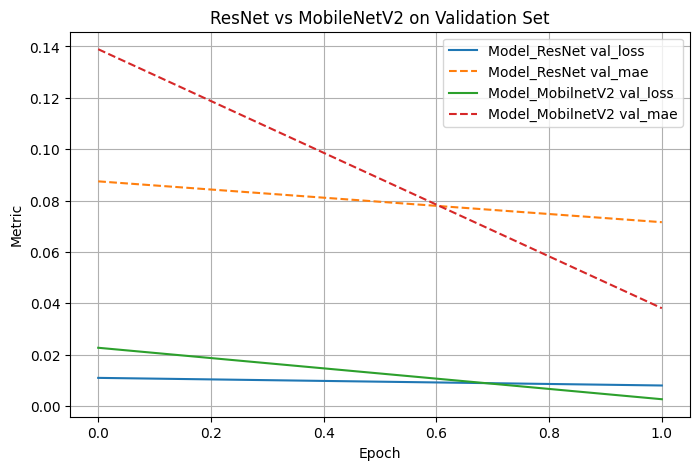

In [108]:
#now just both transfer learning models to see at a smaller level of detail
plt.figure(figsize=(8,5))

for name in ("Model_ResNet", "Model_MobilnetV2"):
    hist = histories[name]
    plt.plot(hist.history['val_loss'], label=f"{name} val_loss", linestyle='-')
    plt.plot(hist.history['val_mae'],  label=f"{name} val_mae",  linestyle='--')

plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("ResNet vs MobileNetV2 on Validation Set")
plt.legend()
plt.grid(True)
plt.show()


# Hyper parameter tuning of final model
Discussion of hyper parameter tuning of final model 

# Results 
Includes multiple different types of assessments on final model (should have lots of options with labeled data)

# Conclusion
### Results and final Model overview
Same as others, revisit results and final model

### What could be improved for next time


### Learning and take aways


### 
